In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp038'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


## read data

In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v3/train_10000_5000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'2kaido_wifi_dataset_v3/test_10000_5000_7.pkl', 'rb') as f:
  test_df = pickle.load(f)

sub_df = pd.read_csv(root_dir/'indoor-location-navigation/sample_submission.csv', index_col=0)

In [6]:
train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32})
test_df = test_df.astype({'timestamp':int})

In [7]:
train_df = train_df.reset_index().rename(columns={'index':'id'})

<AxesSubplot:>

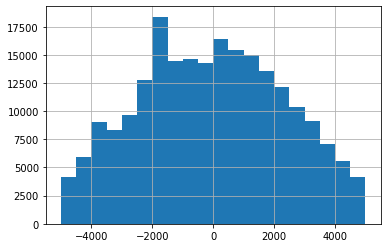

In [8]:
train_df['timediff'].astype(int).hist(bins=20)

In [9]:
train_df

,id,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,...,y,itimestamp,ix,iy,floor,floor_str,path,site_id,timediff,itimediff
0,0,356d66c73c423be835bd5d07cb1ebdfa821d8e23,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,4e601619b7c7d9df8d61490ad2c134f08ea01d61,c3513a636d1a813db081a2ffc33f297b4fefe28d,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,156.842239,1578466134278,113.615387,156.634796,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-1545,-45
1,1,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,156.842239,1578466136278,112.655884,156.358200,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-3512,-12
2,2,f44fa6118fed7198296c8b45b2f2684903d99620,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,5731b8e08abc69d4c4d685c58164059207c93310,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,154.629517,1578466146278,108.098259,155.044403,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,3496,200
3,3,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,c451965585f1bd709a952b68f8c89df943c01065,...,154.629517,1578466148278,107.138763,154.767822,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,1541,245
4,4,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,5731b8e08abc69d4c4d685c58164059207c93310,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,154.629517,1578466149778,106.659012,154.629517,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-397,-193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220460,220460,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,18336f0964fbd470a2ee7116d33b96946c633999,040667e2fdd3a9bbb54e970c430ad6f08416c52e,072159287058774aa9b450c9163129b309bc982b,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,107.011642,1573892866000,128.925217,109.018059,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,-2224,38
220461,220461,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,111.526085,1573892868000,130.645798,110.522873,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,1098,126
220462,220462,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,072159287058774aa9b450c9163129b309bc982b,040667e2fdd3a9bbb54e970c430ad6f08416c52e,1f09251bbfadafb11c63c87963af25238d6bc886,da39a3ee5e6b4b0

In [10]:
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,timediff_95,timediff_96,timediff_97,timediff_98,timediff_99,timestamp,path,site_id,timediff,site_path_timestamp
0,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,ab150ecf6d972b476aeab16317bed6189d9f7cce,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,01e78c97f2c04cdbc7c4159158bb125a9bb558ff,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,1750.0,1751.0,1728.0,1377.0,635.0,1578474563646,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-2331,5a0546857ecc773753327266_046cfa46be49fc1083481...
1,7182afc4e5c212133d5d7d76eb3df6c24618302b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5529.0,5032.0,5029.0,5032.0,4850.0,1578474572654,046cfa46be49fc10834815c6,5a0546857ecc773753327266,4287,5a0546857ecc773753327266_046cfa46be49fc1083481...
2,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,353.0,359.0,353.0,5239.0,3133.0,1578474572654,046cfa46be49fc10834815c6,5a0546857ecc773753327266,4287,5a0546857ecc773753327266_046cfa46be49fc1083481...
3,7182afc4e5c212133d5d7d76eb3df6c24618302b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,2446.0,5241.0,2450.0,2449.0,2451.0,1578474572654,046cfa46be49fc10834815c6,5a0546857ecc773753327266,4287,5a0546857ecc773753327266_046cfa46be49fc1083481...
4,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,9441.0,1879.0,1369.0,7149.0,9619.0,1578474578963,046cfa46be49fc10834815c6,5a0546857ecc773753327266,8136,5a0546857ecc773753327266_046cfa46be49fc1083481...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37460,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,8e69018f6343506344ab13646ccd9447fc2ffb19,c72257cf75d6a411225948bbc4e37ad554e7beda,8e69018f6343506344ab13646ccd9447fc2ffb19,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,efa1fe97c4b2a6c57d98de9c236a109032ceb839,...,2184.0,1796.0,2056.0,1915.0,515.0,1573731151563,fd64de8c4a2fc5ebb0e9f412,5dc8cea7659e181adb076a3f,60121,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...
37461,8e69018f6343506344ab13646ccd9447fc2ffb19,5d998a8668536c4f51004c25f474117fe9555f78,8e69018f6343506344ab13646ccd9447fc2ffb19,5d998a8668536c4f51004c25f474117fe9555f78,c72257cf75d6a411225948bbc4e37ad554e7beda,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6

In [11]:
# remove_id = np.load('../exp033/20s_over_id.npy', allow_pickle=True)
# remove_id.shape

In [12]:
# train_df = train_df[~train_df['id'].isin(remove_id)].reset_index(drop=True)
# train_df

In [13]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
TIMEDIFF_FEATS  = [f'timediff_{i}' for i in range(NUM_FEATS)]

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない

In [14]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids = list(set(wifi_bssids))
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 65550
BSSID TYPES(test): 31876
BSSID TYPES(all): 65628


In [15]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 94
RSSI TYPES(test): 82
RSSI TYPES(all): 176


## preprocessing

In [16]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
    output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
        # output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？ embeddingのpadding用のダミー変数？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df['site_id_str'] = input_df['site_id'].copy()
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    # output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

In [17]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [18]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.ixy = df[['ix', 'iy']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
            timediff = df['timediff'].astype(np.float32).abs().values
            self.weight = 1- (timediff/np.max(timediff))  # lossにかける重み。timediffが大きいほど小さくなる
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
    
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'ixy':self.ixy[idx],
                'floor':self.floor[idx],
                'weight': self.weight[idx]
            }
        else:
            target = {}
        return feature, target

In [19]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, wifi_bssids_size, site_count=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.embedding_layer1 = nn.Sequential(
            nn.Embedding(wifi_bssids_size, embedding_dim),
            nn.Flatten(start_dim=-2)            
        )
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す
        self.embedding_layer2 = nn.Sequential(
            nn.Embedding(site_count, 64),
            nn.Flatten(start_dim=-1)           
        )

        # bssid, site, rssiの出力size
        # feature_size = 2 + (2 * NUM_FEATS * embedding_dim)
        feature_size = 64 + (2 * NUM_FEATS * 64)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(feature_size),
            nn.Dropout(0.3),
            nn.Linear(feature_size, 256),
            nn.ReLU()
        )

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_rssi_bssid = self.embedding_layer1(x['RSSI_BSSID_FEATS'])
        x_site_id = self.embedding_layer2(x['site_id'])
        # x_rssi = self.linear_layer1(x['RSSI_FEATS'])
        x = torch.cat([x_rssi_bssid, x_site_id], dim=-1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        return {"xy": xy, "floor": floor}

In [20]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [21]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.MSELoss(reduction='none')

    def forward(self, input, target, weight):  # weight:timediffによる重みづけ
        input = input.float()
        target = target.float()
        weight = torch.stack((weight, weight), 1).float()  # x,y分でstack
        loss = self.loss(input, target) * weight  # timediffが大きいもののlossはあまり計算しないようにする
        return loss.mean()

In [22]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    
    
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [23]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["ixy"], y['weight'])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["ixy"], y['weight'])
        # f_loss = self.f_criterion(output["floor"], y["floor"], y['weight'])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)

        impe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['ixy'][:, 0]), to_np(y['ixy'][:, 1]), 0)

        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        # self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'iMPE/val', impe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [24]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [25]:
oofs = []  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = model_selection.GroupKFold(n_splits=N_SPLITS)

train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in gkf.split(train.loc[:, 'path'], groups=train.loc[:, 'path'])]
# 今回はtargetを均等に分ける必要はなくpathが均等に分かれればいいのでskf.split()にpathを与えている。
for fold in range(5):
    # 指定したfoldのみループを回す
    if fold not in USE_FOLDS:
        continue

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_idx_for_train, val_idx_for_train = train_fold[fold]
    trn_df = train.loc[trn_idx_for_train, :].reset_index(drop=True)
    trn_df = trn_df.loc[:,BSSID_FEATS + RSSI_FEATS + ['site_id', 'x', 'y', 'ix','iy','floor','timediff']]
    
    val_df = train.loc[val_idx_for_train, :].reset_index(drop=True)
    val_df = val_df.loc[:,BSSID_FEATS + RSSI_FEATS + ['site_id', 'x', 'y', 'ix','iy','floor','timediff']]

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)

    # model
    model = LSTMModel(wifi_bssids_size, site_count)  # +1としているのはLEを1スタートで始めているため
    model_name = model.__class__.__name__

    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=f"../../model/{EXP_NAME}",
        verbose=False,
        filename=f'{model_name}-{fold}')
    
    if MODEL_SAVE:
        callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=False,
        mode='min')
    callbacks.append(early_stop_callback)

    # loggers
    RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
    wandb.init(project='indoor', notes=NOTES, entity='kuto5046', group=RUN_NAME)
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config['model_name'] = model_name
    wandb_config['LB'] = None
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    # pretrained flag
    if PRETRAINED:
        ckpt = torch.load(PRETRAINED_PATH + f'{model_name}-{fold}.ckpt')
        learner.load_state_dict(ckpt['state_dict'])

    if not ONLY_PRED:
        trainer = pl.Trainer(
            logger=loggers, 
            callbacks=callbacks,
            max_epochs=MAX_EPOCHS,
            gpus=[0],
            fast_dev_run=DEBUG,
            deterministic=True,
            # precision=16,
            progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
            )

        trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval() 
    oof_df = train.loc[val_idx_for_train, RSSI_FEATS + TIMEDIFF_FEATS + ['id', 'timestamp', 'x', 'y', 'floor', 'ix', 'iy', 'floor_str','path', 'site_id', 'site_id_str']].reset_index(drop=True)
    # oof_df = train.loc[val_idx_for_train, ['id', 'timestamp', 'x', 'y', 'floor', 'ix', 'iy', 'floor_str','path', 'site_id', 'site_id_str']].reset_index(drop=True)
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oof_df["oof_x"] = oof_x
    oof_df["oof_y"] = oof_y
    oof_df["oof_floor"] = oof_f
    oofs.append(oof_df)
    
    # 補間前のtargetで評価
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['x'].values, oof_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    # 補間後のtargetで評価
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['ix'].values, oof_df['iy'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############

    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub_df.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    # test_preds.to_csv(f'{EXP_NAME}_fold{fold}.csv', index=False)
    predictions.append(test_preds)

    if fold != 4:
        wandb.finish()

Fold 0
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kuto5046 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 0: mean position error 7.570111752432359
fold 0: mean position error 7.303935006690405


Fold 1
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 1: mean position error 7.041041094958383
fold 1: mean position error 6.755166636427551


Fold 2
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 2: mean position error 6.842686197355589
fold 2: mean position error 6.558271012405597


Fold 3
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 3: mean position error 6.925313400086181
fold 3: mean position error 6.636054050529562


Fold 4
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 4: mean position error 7.094625989386071
fold 4: mean position error 6.802328317419999


## validation

In [73]:
if len(USE_FOLDS) > 1:
    oofs_df = pd.concat(oofs)
else:
    oofs_df = oofs[0]

oofs_df['site_path_timestamp'] = oofs_df['site_id_str'].astype(str) + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df = oofs_df.sort_values('site_path_timestamp').reset_index(drop=True)
oofs_df.to_csv("oof.csv", index=False)
oofs_df

,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9,...,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp
0,39,46,47,47,49,49,49,51,52,55,...,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,79.262436,35.651375,0.205538,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
1,40,47,47,48,48,49,49,49,49,49,...,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.296295,33.535130,0.205931,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
2,44,44,44,44,45,45,45,45,46,47,...,76.813652,32.936237,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,86.662872,23.946400,0.205969,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
3,43,44,44,44,45,45,49,49,50,50,...,76.439110,31.319307,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,87.101913,23.149050,0.205791,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
4,43,43,43,44,44,45,45,46,46,47,...,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.743439,21.838287,0.201842,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220460,59,63,66,70,71,71,73,75,75,78,...,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,204.178116,105.088226,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
220461,62,62,63,70,71,73,75,75,78,79,...,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,203.788315,104.344894,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
220462,65,67,68,75,78,79,79,79,81,82,...,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.973663,106.884850,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
220463,62,65,67,75,75,79,79,80,81,82,...,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,207.569855,106.029709,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...


In [27]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
wandb_config['CV'] = oof_score
print(f"CV:{oof_score}")

CV:7.094755403352006


In [28]:
# waypoint補正後のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['CV-i'] = oof_score
print(f"CV:{oof_score}")

CV:6.811149728981925


In [76]:

mean_oofs_df = oofs_df.groupby("site_path_timestamp").mean().reset_index()
mean_oofs_df["site_id_str"] = mean_oofs_df["site_path_timestamp"].str.split("_", expand=True)[0]
mean_oofs_df["path"] = mean_oofs_df["site_path_timestamp"].str.split("_", expand=True)[1]
mean_oofs_df = pd.merge(mean_oofs_df, oofs_df[["path", "floor_str"]].drop_duplicates(), on="path", how="left")

In [29]:
# waypointの平均のx,yでの評価
oof_score = mean_position_error(
    mean_oofs_df['oof_x'], mean_oofs_df['oof_y'], 0, 
    mean_oofs_df['x'], mean_oofs_df['y'], 0
    )
wandb_config['CV(mean)'] = oof_score
print(f"CV:{oof_score}")

CV:6.711041766176843


In [30]:
if len(USE_FOLDS) > 1:
    # foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
    all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()  # 平均でいいんだっけ？
else:
    all_preds = predictions[0]
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.267021,104.663521
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,82.697800,105.373505
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,84.964699,103.951103
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,86.664825,106.717567
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,83.760201,107.410637
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,0,211.185181,98.134605
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,0,206.992462,102.895439
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,0,203.806610,105.155952


In [31]:
all_preds_20s = pd.read_csv('../../exp/exp021/exp021_diff_weight_v2_cost_snap_sub.csv', index_col=0)
with open(root_dir/'2kaido_wifi_dataset_v2/test_20000_7.pkl', 'rb') as f:
  tmp = pickle.load(f)
# site_path_timestampをoriginalに戻す
all_preds_20s.index = tmp['site_path_timestamp']

# オリジナルのsite_path_timestampをもとにmerge
sub = pd.merge(all_preds_20s, all_preds, how='left', on='site_path_timestamp')[['floor_y', 'x_y', 'y_y']]
sub = sub.rename(columns={'floor_y': 'floor', 'x_y': 'x', 'y_y': 'y'})

# 欠損している箇所は補間
sub['floor'].fillna(all_preds_20s['floor'], inplace=True)
sub['x'].fillna(all_preds_20s['x'].astype(np.float32), inplace=True)
sub['y'].fillna(all_preds_20s['y'].astype(np.float32), inplace=True)

# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
sub.index = sub_df.index
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0.0,85.267021,104.663521
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0.0,82.697800,105.373505
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0.0,84.964699,103.951103
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0.0,86.664825,106.717567
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0.0,83.760201,107.410637
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0.0,211.185181,98.134605
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0.0,206.992462,102.895439
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0.0,203.806610,105.155952


In [32]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv(root_dir / 'simple-99-accurate-floor-model/submission.csv')
sub['floor'] = simple_accurate_99['floor'].values
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.267021,104.663521
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,82.697800,105.373505
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.964699,103.951103
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.664825,106.717567
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,83.760201,107.410637
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,211.185181,98.134605
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,206.992462,102.895439
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,203.806610,105.155952


## testのwaypointを予測結果(wifi)から再度線形補完

In [33]:
# import sys 
# sys.path.append("../../")
# from multiprocessing import Pool
# from src.io_f import read_data_file
# from scipy import interpolate

# # timestampとwaypointを元に線形補完しtarget_timestampに対応するtarget_waypointを求める　
# def wifi_waypoint_by_linear_interpolation(
#     observed_timestamp: np.ndarray, 
#     observed_x:np.ndarray, 
#     observed_y:np.ndarray, 
#     target_timestamp:np.ndarray, 
#     delta_time=500
#     ):
#     """
#     observed: すでに知っている情報
#     observed-timestamp,x,yは全て同じ要素数となる

#     observedの情報からfitting関数を作成
#     """
#     target_waypoint_list = []
#     num_interpolation = len(observed_timestamp) - 1  # 補完回数 
#     # 各waypoint間で線形補完
#     for i in range(num_interpolation):
#         # 潜在的なtimestampを作成(これのどれかにwifiを当てはめるような形)
#         n_split = int((max(observed_timestamp[i:i+2]) - min(observed_timestamp[i:i+2])) / delta_time) + 2  # delta_time刻みとなるように分割数を指定(+2は始点と終点分)
#         latent_timestamp = np.linspace(min(observed_timestamp[i:i+2]), max(observed_timestamp[i:i+2]), n_split).astype(int) 
        
#         # xが昇順の場合はlatentも昇順になるようにする
#         if observed_x[i] < observed_x[i+1]:
#             latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)
#         # xが降順の場合はlatentも降順になるようにする
#         else:
#             latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)[::-1]
        
#         # 線形補完関数の適用
#         fitting_func = interpolate.interp1d(observed_x[i:i+2], observed_y[i:i+2])

#         # wifiのtimestampに最も近いものをsplit_timestampから取得しそれに対応するwaypointをwifiのwaypointとして取得
#         target_x = []
#         target_y = []

#         # 区間内のwifiデータのみ考える
#         if i == num_interpolation-1:
#             # pathの最後の区間にobserved timestampより未来にあるtimestampに対処
#             target_idx = min(observed_timestamp[i:i+2]) <= target_timestamp
#         elif i == 0:
#             # pathの最初の区間にobserved timestampより過去にあるtimestampに対処
#             target_idx = target_timestamp < max(observed_timestamp[i:i+2])
#         else:
#             target_idx = (min(observed_timestamp[i:i+2]) <= target_timestamp) & (target_timestamp < max(observed_timestamp[i:i+2]))
#         target_use_timestamp = target_timestamp[target_idx]

#         # timestampが最も近いものをtarget waypointとして取得
#         for t in target_use_timestamp:
#             idx = np.abs(latent_timestamp - t).argmin()  # targetとtimestampが最も近いものをlatentから取得
#             target_x.append(latent_x[idx])
#             # 原因はよくわからないがfittingするとnanが発生する場合がある
#             # その場合は元の値をそのまま使う
#             if np.isnan(fitting_func(latent_x[idx])).sum() > 0:
#                 # print('yに欠損値あり')
#                 idx = np.abs(observed_timestamp - t).argmin()  # 0→wifiの最初のtimestampで問題が起きている
#                 target_y.append(observed_y[idx])
                
#             else:
#                 target_y.append(fitting_func(latent_x[idx]))

#         assert len(target_x) == len(target_y)
#         target_waypoint = np.stack([target_x, target_y], axis=1)
#         target_waypoint_list.append(target_waypoint)

#     target_waypoint = np.concatenate(target_waypoint_list)
#     return target_waypoint

In [ ]:
# timediff = pd.read_csv(root_dir/'test_path_timediff.csv').rename(columns={'path_id':'path'})
# timediff

In [ ]:
# _test_df = test_df.merge(timediff, on='path')
# test_df['_timestamp'] = (_test_df['timestamp'].astype(int) - _test_df['time_diff'].astype(int)).astype(str).str.zfill(13)
# test_df['site_path_timestamp'] = test_df['site_id'] + '_' + test_df['path'] + '_' + test_df['_timestamp']

In [ ]:
# pd.merge(test_df[['site_path_timestamp', 'timediff']], sub, on="site_path_timestamp", how='left')

In [ ]:
# test_df['wifi_timestamp'] = test_df['timestamp'].astype(int) - test_df['timediff'].astype(int)
# test_df

In [ ]:
# # 線形補完の例
# path = test_df['path'].unique()[23]  #15
# df = test_df[test_df['path']==path]

# waypoint = wifi_waypoint_by_linear_interpolation(
#     observed_timestamp=df['wifi_timestamp'].astype(int).values, 
#     observed_x=df['x'].values,
#     observed_y=df['y'].values, 
#     target_timestamp=df['timestamp'].astype(int).values
#     )
# print(len(df), len(waypoint))

# import matplotlib.pyplot as plt
# # print(df["timestamp"].astype(int) - df["timestamp"].astype(int).values[0])
# plt.plot(df["x"].values, df["y"].values, ls='--', marker="o", label='wifi')
# plt.plot(waypoint[:,0], waypoint[:,1], ls='--', marker="o", label='waypoint')
# plt.legend()

In [ ]:
# # 線形補完でwaypointを修正
# waypoint_dfs = []
# for path,df in test_df.groupby('path'):  #15
#     tmp_waypoint = wifi_waypoint_by_linear_interpolation(
#         observed_timestamp=df['wifi_timestamp'].astype(int).values, 
#         observed_x=df['x'].values,
#         observed_y=df['y'].values, 
#         target_timestamp=df['timestamp'].astype(int).values
#         )
#     df['_x'] = tmp_waypoint[:,0]
#     df['_y'] = tmp_waypoint[:,1]
#     waypoint_dfs.append(df)

# waypoint_df = pd.concat(waypoint_dfs).reset_index(drop=True)
# waypoint_df

In [ ]:
# import matplotlib.pyplot as plt
# (waypoint_df['x'] - waypoint_df['_x']).hist(label='x')
# (waypoint_df['y'] - waypoint_df['_y']).hist(label='y')
# plt.legend()

In [ ]:
# sub = sub.merge(waypoint_df[['site_path_timestamp', '_x', '_y']], on='site_path_timestamp').set_index('site_path_timestamp')
# sub = sub.drop(['x','y'], axis=1).rename(columns={'_x':'x', '_y':'y'})
# sub

In [34]:
sub.to_csv(EXP_NAME + '_sub.csv')

## 後処理

## cost minimaization

In [35]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f
from scipy.signal import butter, lfilter

In [36]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

In [37]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions


def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    example = read_data_file(root_dir/ f'indoor-location-navigation/test/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def correct_path_train(args):
    #print(args)
    (site_id, path, floor), path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/train/{site_id}/{floor}/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]

    try:
        delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    except:
        return pd.DataFrame({
            'site_path_timestamp' : path_df['site_path_timestamp'],
            'floor' : path_df['floor'],
            'x' : path_df['x'].to_numpy(),
            'y' : path_df['y'].to_numpy()
        })
    

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)


    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)


<>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-37-a1a172f865b0>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if current_state is 'above':


In [38]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [80]:
%%time

oofs_df = oofs_df.rename(columns={'x':'target_x', 'y':'target_y', 'oof_x':'x', 'oof_y':'y'})
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path_train, oofs_df.groupby(['site_id_str', 'path', 'floor_str']))
    dfs = tqdm(dfs)
    dfs = list(dfs)

oof_post_process = pd.concat(dfs).sort_index()
oofs_df['oof_min_x'] = oof_post_process['x']
oofs_df['oof_min_y'] = oof_post_process['y']

# 元に戻す
oofs_df = oofs_df.rename(columns={'x':'oof_x', 'y':'oof_y'})
oofs_df

10824it [05:32, 32.58it/s]
CPU times: user 55.5 s, sys: 13.6 s, total: 1min 9s
Wall time: 5min 37s


,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9,...,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y
0,39,46,47,47,49,49,49,51,52,55,...,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,79.262436,35.651375,0.205538,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,81.957298,35.740396
1,40,47,47,48,48,49,49,49,49,49,...,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.296295,33.535130,0.205931,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,81.960994,35.740518
2,44,44,44,44,45,45,45,45,46,47,...,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,86.662872,23.946400,0.205969,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.976876,26.227376
3,43,44,44,44,45,45,49,49,50,50,...,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,87.101913,23.149050,0.205791,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.975056,26.233652
4,43,43,43,44,44,45,45,46,46,47,...,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.743439,21.838287,0.201842,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.967576,26.244160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220460,59,63,66,70,71,71,73,75,75,78,...,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,204.178116,105.088226,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.524569,103.314520
220461,62,62,63,70,71,73,75,75,78,79,...,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,203.788315,104.344894,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.514486,103.316163
220462,65,67,68,75,78,79,79,79,81,82,...,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.973663,106.884850,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.262874,105.698911
220463,62,65,67,75,75,79,79,80,81,82,...,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,207.569855,106.029709,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.255555,105.697515


In [40]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
wandb_config['CV_cost'] = oof_score_post_process
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:5.566220321576894


In [41]:
# waypoint補正後のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['iCV_cost'] = oof_score_post_process
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:5.825926163284099


In [77]:
%%time

mean_oofs_df = mean_oofs_df.rename(columns={'x':'target_x', 'y':'target_y', 'oof_x':'x', 'oof_y':'y'})
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path_train, mean_oofs_df.groupby(['site_id_str', 'path', 'floor_str']))
    dfs = tqdm(dfs)
    dfs = list(dfs)

oof_post_process = pd.concat(dfs).sort_index()
mean_oofs_df['oof_min_x'] = oof_post_process['x']
mean_oofs_df['oof_min_y'] = oof_post_process['y']

# 元に戻す
mean_oofs_df = mean_oofs_df.rename(columns={'x':'oof_x', 'y':'oof_y'})
mean_oofs_df

10824it [05:29, 32.87it/s]
CPU times: user 54 s, sys: 13.2 s, total: 1min 7s
Wall time: 5min 34s


,site_path_timestamp,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,...,iy,site_id,oof_x,oof_y,oof_floor,site_id_str,path,floor_str,oof_min_x,oof_min_y
0,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,39.50,46.500000,47.000000,47.5,48.500000,49.00,49.000000,50.000000,50.500000,...,36.776455,0.0,80.779366,34.593254,0.205734,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,79.917322,38.226021
1,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,43.40,43.800000,43.800000,44.2,44.800000,45.60,46.800000,47.200000,47.600000,...,29.537575,0.0,85.071716,22.981852,0.204076,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,80.273398,28.986984
2,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,38.50,41.000000,41.000000,42.0,42.250000,42.25,42.500000,43.000000,44.000000,...,12.322587,0.0,83.649147,19.586538,0.200835,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,81.216332,15.582728
3,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,34.75,36.750000,37.000000,38.0,38.750000,39.25,39.750000,40.000000,40.000000,...,8.606377,0.0,84.099625,20.370808,0.201358,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,82.636609,12.983947
4,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,45.75,47.000000,48.000000,49.0,49.250000,50.25,50.750000,51.000000,51.750000,...,13.241647,0.0,84.932693,21.327747,0.202558,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,91.452834,18.666075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71177,5dc8cea7659e181adb076a3f_5dd7c1189191710006b56...,65.00,72.000000,74.000000,75.5,79.000000,79.50,80.500000,81.500000,82.000000,...,106.415894,23.0,197.866638,104.800507,0.311593,5dc8cea7659e181adb076a3f,5dd7c1189191710006b568d0,B1,198.991016,107.735382
71178,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,63.00,65.500000,67.500000,70.5,75.500000,78.50,79.000000,80.500000,81.000000,...,107.215134,23.0,206.780365,104.854927,0.000000,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,B1,210.992907,103.264496
71179,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,61.75,63.250000,64.750000,70.0,75.000000,75.25,76.750000,78.000000,78.250000,...,108.919197,23.0,205.852310,104.196205,0.000000,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,B1,201.773939,105.800882
71180,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,61.40,64.000000,66.000000,70.0,71.000000,71.40,73.600000,75.000000,75.800000,...,108.179710,23.0,204.063019,103.621780,0.000000,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,B1,201.176561,103.515950


In [79]:
# waypointの平均のx,yでの評価
oof_score = mean_position_error(
    mean_oofs_df['oof_min_x'], mean_oofs_df['oof_min_y'], 0, 
    mean_oofs_df['target_x'], mean_oofs_df['target_y'], 0
    )
wandb_config['CV_cost(mean)'] = oof_score
print(f"CV:{oof_score}")

CV:5.441617175138636


In [81]:
sub = sub.reset_index()
sub_org = sub.copy()
tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)
sub

,index,site_path_timestamp,floor,x,y,site,path,timestamp
0,0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.267021,104.663521,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9.0
1,1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,82.697800,105.373505,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9017.0
2,2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.964699,103.951103,5a0546857ecc773753327266,046cfa46be49fc10834815c6,15326.0
3,3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.664825,106.717567,5a0546857ecc773753327266,046cfa46be49fc10834815c6,18763.0
4,4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.760201,107.410637,5a0546857ecc773753327266,046cfa46be49fc10834815c6,22328.0
...,...,...,...,...,...,...,...,...
10128,10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,211.185181,98.134605,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,82589.0
10129,10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.992462,102.895439,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,85758.0
10130,10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,203.806610,105.155952,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,90895.0
10131,10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,202.334366,111.245056,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,96899.0


In [82]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby(['path']))
    dfs = tqdm(dfs)
    dfs = list(dfs)
new_sub = pd.concat(dfs).sort_values('site_path_timestamp')
new_sub

626it [00:51, 12.18it/s]


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,90.067450,97.485010
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,80.966180,99.844459
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,82.865739,104.663919
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.725645,108.367646
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.234355,112.028719
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,208.996813,98.987745
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,207.116243,102.516847
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,203.306577,108.348592
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,196.214228,112.962323


In [83]:
new_sub.to_csv(RUN_NAME + '_cost_sub.csv', index=False)

## snap to grid

In [84]:
from scipy.spatial.distance import cdist
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()


In [85]:
train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')
# 線形補完しているwaypointをtrain_waypoints（grid）とする。gridを増やすのが狙い。
# train_waypoints = oofs_df[['oof_x', 'oof_y', 'timestamp', 'site_id_str', 'floor', 'floor_str', 'path']]
# train_waypoints = train_waypoints.rename(columns={'oof_x':'x', 'oof_y':"y", 'site_id_str':"site", 'floor_str':'floorNo'})

snap_df = oofs_df[['site_path_timestamp','floor','oof_min_x','oof_min_y']].copy()
snap_df = snap_df.rename(columns={'oof_min_x':'x', 'oof_min_y':'y'})
snap_df = sub_process(snap_df, train_waypoints)
snap_df = add_xy(snap_df)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(snap_df.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['oof_min_snap_x'] = d['matched_point'].apply(lambda x: x[0])
    d['oof_min_snap_y'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

# 上書き
snap_df = pd.concat(ds).sort_index()
snap_df

100%|██████████| 139/139 [01:26<00:00,  1.61it/s]


,site,path,timestamp,site_path_timestamp,floor,x,y,floorNo,isTrainWaypoint,xy,matched_point,oof_min_snap_x,oof_min_snap_y
0,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,81.957298,35.740396,F3,False,"(81.9572976444582, 35.74039555632386)","(80.6814, 39.265667)",80.68140,39.265667
1,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,81.960994,35.740518,F3,False,"(81.96099429978243, 35.74051766982102)","(80.6814, 39.265667)",80.68140,39.265667
2,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,82.976876,26.227376,F3,False,"(82.97687576524575, 26.227376166173126)","(84.22669, 27.13862)",84.22669,27.138620
3,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,82.975056,26.233652,F3,False,"(82.9750562375584, 26.233652414924265)","(84.22669, 27.13862)",84.22669,27.138620
4,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,82.967576,26.244160,F3,False,"(82.96757572603761, 26.244159943038937)","(84.22669, 27.13862)",84.22669,27.138620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220460,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,202.524569,103.314520,B1,False,"(202.52456937913993, 103.31452041201509)","(204.21092, 106.165436)",204.21092,106.165436
220461,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,202.514486,103.316163,B1,False,"(202.51448585205307, 103.31616277736342)","(204.21092, 106.165436)",204.21092,106.165436
220462,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420753754,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,210.262874,105.698911,B1,False,"(210.2628742787032, 105.69891091849424)","(208.15857, 104.7078)",208.15857,104.707800
220463,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420753754,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,210.255555,105.697515,B1,False,"(210.25555533595283, 105.69751532737935)","(208.15857, 104.7078)",208.15857,104.707800


In [86]:
oofs_df['oof_min_snap_x'] = snap_df['oof_min_snap_x']
oofs_df['oof_min_snap_y'] = snap_df['oof_min_snap_y']
oofs_df

,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9,...,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y,oof_min_snap_x,oof_min_snap_y
0,39,46,47,47,49,49,49,51,52,55,...,0,5a0546857ecc773753327266,79.262436,35.651375,0.205538,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,81.957298,35.740396,80.68140,39.265667
1,40,47,47,48,48,49,49,49,49,49,...,0,5a0546857ecc773753327266,82.296295,33.535130,0.205931,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,81.960994,35.740518,80.68140,39.265667
2,44,44,44,44,45,45,45,45,46,47,...,0,5a0546857ecc773753327266,86.662872,23.946400,0.205969,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.976876,26.227376,84.22669,27.138620
3,43,44,44,44,45,45,49,49,50,50,...,0,5a0546857ecc773753327266,87.101913,23.149050,0.205791,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.975056,26.233652,84.22669,27.138620
4,43,43,43,44,44,45,45,46,46,47,...,0,5a0546857ecc773753327266,82.743439,21.838287,0.201842,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.967576,26.244160,84.22669,27.138620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220460,59,63,66,70,71,71,73,75,75,78,...,23,5dc8cea7659e181adb076a3f,204.178116,105.088226,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.524569,103.314520,204.21092,106.165436
220461,62,62,63,70,71,73,75,75,78,79,...,23,5dc8cea7659e181adb076a3f,203.788315,104.344894,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.514486,103.316163,204.21092,106.165436
220462,65,67,68,75,78,79,79,79,81,82,...,23,5dc8cea7659e181adb076a3f,206.973663,106.884850,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.262874,105.698911,208.15857,104.707800
220463,62,65,67,75,75,79,79,80,81,82,...,23,5dc8cea7659e181adb076a3f,207.569855,106.029709,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.255555,105.697515,208.15857,104.707800


In [87]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
wandb_config['CV_cost_snap'] = oof_score_post_process
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min + snap) CV:5.03965921875258


In [88]:
# waypoint補正後のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['iCV_cost_snap'] = oof_score_post_process
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min + snap) CV:5.649768607834974


In [89]:
train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')
# 線形補完しているwaypointをtrain_waypoints（grid）とする。gridを増やすのが狙い。
# train_waypoints = oofs_df[['oof_x', 'oof_y', 'timestamp', 'site_id_str', 'floor', 'floor_str', 'path']]
# train_waypoints = train_waypoints.rename(columns={'oof_x':'x', 'oof_y':"y", 'site_id_str':"site", 'floor_str':'floorNo'})

mean_snap_df = mean_oofs_df[['site_path_timestamp','floor','oof_min_x','oof_min_y']].copy()
mean_snap_df = mean_snap_df.rename(columns={'oof_min_x':'x', 'oof_min_y':'y'})
mean_snap_df = sub_process(mean_snap_df, train_waypoints)
mean_snap_df = add_xy(mean_snap_df)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(mean_snap_df.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['oof_min_snap_x'] = d['matched_point'].apply(lambda x: x[0])
    d['oof_min_snap_y'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

# 上書き
mean_snap_df = pd.concat(ds).sort_index()
mean_snap_df

100%|██████████| 139/139 [00:28<00:00,  4.81it/s]


,site,path,timestamp,site_path_timestamp,floor,x,y,floorNo,isTrainWaypoint,xy,matched_point,oof_min_snap_x,oof_min_snap_y
0,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,79.917322,38.226021,F3,False,"(79.9173217701555, 38.22602129626547)","(80.6814, 39.265667)",80.681400,39.265667
1,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,80.273398,28.986984,F3,False,"(80.27339756660524, 28.986984322265503)","(78.469894, 30.721445000000003)",78.469894,30.721445
2,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368793535,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,81.216332,15.582728,F3,False,"(81.21633224678604, 15.582728498643416)","(81.30773, 15.669319)",81.307730,15.669319
3,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368798851,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,82.636609,12.983947,F3,False,"(82.63660881850853, 12.983947243402586)","(81.30773, 15.669319)",81.307730,15.669319
4,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368814782,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,91.452834,18.666075,F3,False,"(91.45283365463044, 18.666074844247348)","(90.43365, 18.036816)",90.433650,18.036816
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71177,5dc8cea7659e181adb076a3f,5dd7c1189191710006b568d0,1574420722415,5dc8cea7659e181adb076a3f_5dd7c1189191710006b56...,-1.0,198.991016,107.735382,B1,False,"(198.9910163871579, 107.7353818586984)","(200.75478, 106.75563)",200.754780,106.755630
71178,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420726383,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,210.992907,103.264496,B1,False,"(210.9929073854088, 103.26449550849071)","(213.61757000000003, 103.37845)",213.617570,103.378450
71179,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420736142,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,201.773939,105.800882,B1,False,"(201.7739390001386, 105.80088184359103)","(200.75478, 106.75563)",200.754780,106.755630
71180,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,201.176561,103.515950,B1,False,"(201.1765614433713, 103.51595040343558)","(200.75478, 106.75563)",200.754780,106.755630


In [90]:
mean_oofs_df['oof_min_snap_x'] = mean_snap_df['oof_min_snap_x']
mean_oofs_df['oof_min_snap_y'] = mean_snap_df['oof_min_snap_y']
mean_oofs_df

,site_path_timestamp,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,...,oof_x,oof_y,oof_floor,site_id_str,path,floor_str,oof_min_x,oof_min_y,oof_min_snap_x,oof_min_snap_y
0,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,39.50,46.500000,47.000000,47.5,48.500000,49.00,49.000000,50.000000,50.500000,...,80.779366,34.593254,0.205734,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,79.917322,38.226021,80.681400,39.265667
1,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,43.40,43.800000,43.800000,44.2,44.800000,45.60,46.800000,47.200000,47.600000,...,85.071716,22.981852,0.204076,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,80.273398,28.986984,78.469894,30.721445
2,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,38.50,41.000000,41.000000,42.0,42.250000,42.25,42.500000,43.000000,44.000000,...,83.649147,19.586538,0.200835,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,81.216332,15.582728,81.307730,15.669319
3,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,34.75,36.750000,37.000000,38.0,38.750000,39.25,39.750000,40.000000,40.000000,...,84.099625,20.370808,0.201358,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,82.636609,12.983947,81.307730,15.669319
4,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,45.75,47.000000,48.000000,49.0,49.250000,50.25,50.750000,51.000000,51.750000,...,84.932693,21.327747,0.202558,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,F3,91.452834,18.666075,90.433650,18.036816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71177,5dc8cea7659e181adb076a3f_5dd7c1189191710006b56...,65.00,72.000000,74.000000,75.5,79.000000,79.50,80.500000,81.500000,82.000000,...,197.866638,104.800507,0.311593,5dc8cea7659e181adb076a3f,5dd7c1189191710006b568d0,B1,198.991016,107.735382,200.754780,106.755630
71178,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,63.00,65.500000,67.500000,70.5,75.500000,78.50,79.000000,80.500000,81.000000,...,206.780365,104.854927,0.000000,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,B1,210.992907,103.264496,213.617570,103.378450
71179,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,61.75,63.250000,64.750000,70.0,75.000000,75.25,76.750000,78.000000,78.250000,...,205.852310,104.196205,0.000000,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,B1,201.773939,105.800882,200.754780,106.755630
71180,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,61.40,64.000000,66.000000,70.0,71.000000,71.40,73.600000,75.000000,75.800000,...,204.063019,103.621780,0.000000,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,B1,201.176561,103.515950,200.754780,106.755630


In [91]:
# waypointの平均のx,yでの評価
oof_score = mean_position_error(
    mean_oofs_df['oof_min_snap_x'], mean_oofs_df['oof_min_snap_y'], 0, 
    mean_oofs_df['target_x'], mean_oofs_df['target_y'], 0
    )
wandb_config['CV_cost_snap(mean)'] = oof_score
print(f"CV:{oof_score}")

CV:4.799196801709294


In [92]:
# x_pred = oofs_df["oof_min_snap_x"]
# y_pred = oofs_df["oof_min_snap_y"]
# f_pred = oofs_df["floor"]  # 正解を与える
# x_true = oofs_df["wifi_x"]
# y_true = oofs_df["wifi_y"]
# f_true = oofs_df["floor"]
# site_arr = oofs_df["site_id_str"]
# df_result_site3 = calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr)
# df_result_site3.style.bar(subset=['n_sample', 'score'], color=['teal'])

In [93]:
# site_eval_report(df_result_site3)

In [94]:
# train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')

new_sub = sub_process(new_sub, train_waypoints)
new_sub = add_xy(new_sub)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in new_sub.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

new_sub2 = pd.concat(ds)

In [95]:
new_sub2 = new_sub2[['site_path_timestamp','floor','x_','y_']].sort_index()
new_sub2 = new_sub2.rename(columns={'x_':'x', 'y_':'y'})
new_sub2

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,80.718400,107.197110
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.596040,98.605774
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.511300,107.841324
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.825880,109.711815


In [96]:
new_sub2.to_csv(RUN_NAME + '_cost_snap_sub.csv', index=False)

In [97]:
# import matplotlib.pyplot as plt
# df_result_site1['score'].plot(label='oof')
# df_result_site2['score'].plot(label='cost')
# df_result_site3['score'].plot(label='cost+snap')
# plt.legend()
# plt.grid()
# plt.savefig('site_result.png')

In [98]:
wandb.finish()